In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jul_weekday_PM_ext.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 22  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 484 entries:
  (6,9)   => 147.828363
  (18,3)  => 0.0
  (21,13) => 0.0
  (22,16) => 0.0
  (15,17) => 763.850987
  (22,14) => 0.0
  (13,9)  => 0.0
  (8,9)   => 2.0e-6
  (9,1)   => 0.0
  (17,14) => 69.204827
  (16,6)  => 0.0
  (16,12) => 0.0
  (16,13) => 0.0
  (22,2)  => 0.0
  (7,16)  => 1.0e-6
  (1,12)  => 2.0e-6
  (4,5)   => 0.0
  (11,8)  => 307.803974
  (18,21) => 0.0
  (19,4)  => 0.0
  (20,13) => 0.0
  (15,4)  => 0.0
  (6,18)  => 0.0
  (5,16)  => 0.0
  (4,9)   => 0.0
  ⋮       => ⋮

In [11]:
using JSON

link_day_minute_Jul_dict = readall("../temp_files/link_day_minute_Jul_dict_ext_JSON_insert_links_adjusted.json");
link_day_minute_Jul_dict = replace(link_day_minute_Jul_dict, "NaN", 0);

link_day_minute_Jul_dict = JSON.parse(link_day_minute_Jul_dict);

In [12]:
# week_day_Jul_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]

# training set 1
week_day_Jul_list_1 = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19]

# training set 2
week_day_Jul_list_2 = [2, 3, 4, 5, 6, 9, 10, 20, 23, 24, 25, 26, 27, 30, 31]

# training set 3
week_day_Jul_list_3 = [11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]


arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Jul_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:73
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["PM_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Jul_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:73
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["PM_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Jul_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:73
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["PM_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 484 entries:
  (6,9)   => [147.828363,147.828363,147.828363,147.828363,147.828363,147.828363…
  (18,3)  => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (21,13) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (22,16) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (15,17) => [763.850987,763.850987,763.850987,763.850987,763.850987,763.850987…
  (22,14) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (13,9)  => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (8,9)   => [2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.…
  (17,14) => [69.204827,69.204827,69.204827,69.204827,69.204827,69.204827,69.20…
  (9,1)   => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (16,6)  => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (16,12) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (16,13) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [15]:
flow_data_3

74x14 Array{Float64,2}:
 1497.48    1459.39         1026.57    …   979.2     1613.15       
 1026.14     959.476         652.242       692.896    658.406      
 1879.76    2005.81         1686.67       1472.22    2098.19       
 3205.71    3064.39         2834.86       3026.6     2912.79       
  872.185    771.119         632.988       823.417    505.202      
 2215.72    2899.92         2013.34    …  1686.04    2006.8        
   58.6942    31.3881        132.099       426.319    152.842      
  897.051    674.057         347.707       585.075    469.91       
  433.266    433.956         351.65        252.115    297.21       
  919.212    907.196         896.993       754.992    400.707      
 2586.44    2310.59         2458.24    …  2451.75    2746.29       
 3287.24    3786.15         2122.54       2081.18    3753.0        
 4081.93    4532.45         3802.3        2113.96    4473.45       
    ⋮                                  ⋱                           
 4633.28    4751.3      

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Jul_PM = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [8]
c_grid = .5
lamb_grid = [10. .^(4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Jul_PM[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Jul_PM[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Jul_PM[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Jul_PM_ext.json", "w")

JSON.print(outfile, coeffs_dict_Jul_PM)

close(outfile)

In [19]:
coeffs_dict_Jul_PM_ = readall("../temp_files/coeffs_dict_Jul_PM_ext.json")
coeffs_dict_Jul_PM_ = JSON.parse(coeffs_dict_Jul_PM_)

Dict{String,Any} with 3 entries:
  "(8,0.5,10000.0,2)" => {1.0,-0.0014122066592427778,0.044241880477702215,-0.113…
  "(8,0.5,10000.0,1)" => {1.0,-0.0013873991316329748,0.04321661753561074,-0.1081…
  "(8,0.5,10000.0,3)" => {1.0,-0.0003513599623428636,0.03571622527032283,-0.1321…

In [20]:
coeffs_dict_Jul_PM_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0       
 -0.0013874 
  0.0432166 
 -0.108149  
  0.286009  
 -0.233922  
  0.176105  
 -0.00375305
 -0.00427429

/home/jzh/.julia/v0.3/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
INFO: Loading help data...


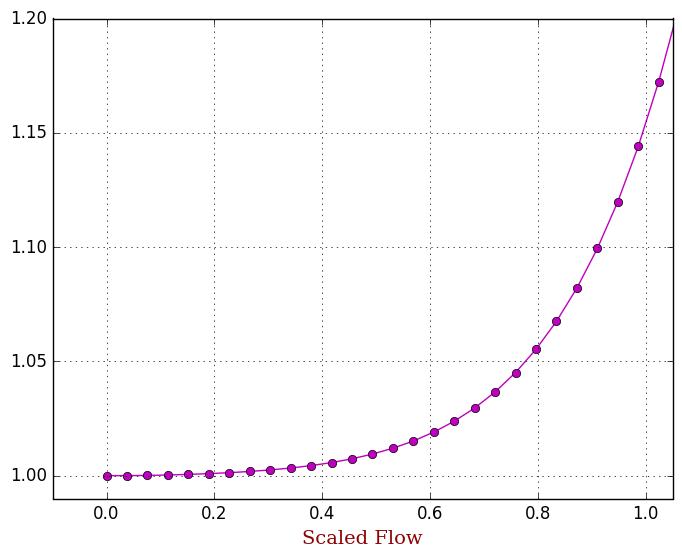

In [21]:
using PyPlot

fcoeffs = coeffs_dict_Jul_PM_["(8,0.5,10000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Jul_PM")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jul_PM_ext.pdf")